In [32]:
import numpy as np
from numpy import sin,arcsin, cos,pi
from scipy.integrate import odeint, solve_ivp
from scipy.linalg import *
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib import animation
from IPython.display import HTML

def rotA(theta):
    '''This function returns a 2x2 rotation matrix to convert the 
    rotated coordinate to the global coordinate system
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    A : 2x2 array to rotate a coordinate system at angle theta to global x-y
    '''
    A=np.zeros((2,2))
    A=np.array([[np.cos(theta), -np.sin(theta)],
               [np.sin(theta), np.cos(theta)]])
    
    return A

def A_theta(theta):
    '''This function returns a 2x2 rotation matrix derivative 
    input is angle in radians
        
    Parameters
    ----------
    theta : angle in radians
    
    Returns
    -------
    dAda : 2x2 array derivative of `rotA`
    '''
    dAda=np.array([[-np.sin(theta), -np.cos(theta)],
                   [np.cos(theta), -np.sin(theta)]])
    return dAda

In [33]:
#Solve for the first set of generalized coordinates given initial conditions

m1 = 0.1 # kg
m2 = 1   # kg
l  = 1   #m
k  = 40  #N/m
g=9.81

q0 = [0, 0, 0, l/2, 0,0]

def C_link(q,t):
    q1 = q[0:6]
    C=np.zeros(4)
    C[0:2] = q1[0:2]+rotA(q1[2])@np.array([0, 0])-q1[3:5]-rotA(q1[5])@np.array([-l/2, 0])
    C[2:4] = q1[1:3]
    return C

def Cq_pin(q,t):
    qi=q[0:3]
    qj=q[3:6]
    ui=np.array([0,0])
    uj=np.array([-l/2,0])
    Cq_1=np.block([np.eye(2), A_theta(qi[2])@ui[:,np.newaxis] ])
    Cq_2=np.block([-np.eye(2), -A_theta(qj[2])@uj[:,np.newaxis] ])
    Cq_3=np.block([np.zeros([2])[:,np.newaxis], np.eye(2)])
    Cq_4=np.zeros([2,3])
    Cq_pin=np.block([[Cq_1, Cq_2],[Cq_3, Cq_4]])
    return Cq_pin

def Bi_link(q, t):
    Cq = Cq_pin(q,t)
    Cqd= Cq[0:4,1:5]
    Cqi= np.block([Cq[0:4,0][:,np.newaxis],Cq[0:4,5][:,np.newaxis]])
    Bi=np.vstack((-np.linalg.inv(Cqd)@Cqi,np.eye(2)))
    return Bi

def eom_bar(t, y):
    #Here y = [Rx1, dRx1, Theta2, dTheta2]
    #Such that dy = [dRx1, ddRx1, dTheta2, ddTheta2]
    
    global q0
    q0[1]=y[0]
    q0[5]=y[2]
    
    q = fsolve(lambda q: np.block([C_link(q, t),q[1]-y[0],q[5]-y[2]]),q0, \
            fprime= lambda q: np.vstack((Cq_pin(q,t),np.array([1,0,0,0,0,0]),np.array([0,0,0,0,0,1]))))
    
    Bi = Bi_link(q, t)
    M  = np.diag([m1,m1,0,m2,m2,m2*l**2/12]) 
    Qe = np.array([-k, 0, 0, 0,-m2*g,0])
    dy = np.zeros(y.shape)
    dy[0]=y[1]
    dy[2]=y[3]
    sol  =solve(Bi.T@M@Bi,Bi.T@Qe)
    dy[1]=sol[0]
    dy[3]=sol[1]
    return dy, q

In [30]:
lambda t, y: eom_bar(t, y)[0] # <-- only grab the first output from eom_bar

t = np.linspace(0,4)
sol=solve_ivp(lambda t, y: eom_bar(t, y)[0], 
              t_span = [0,t.max()], 
              y0 = [0, 0, 0, 0], 
              t_eval = t)

C:\Users\joshu\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\joshu\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Text(0.5, 1.0, 'independent general coord theta')

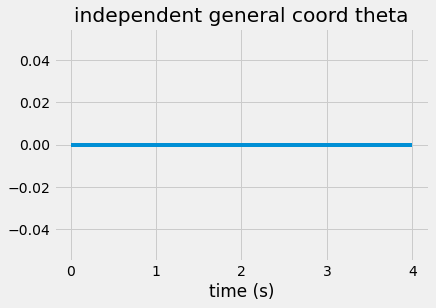

In [37]:
plt.plot(sol.t,sol.y[2])

plt.xlabel('time (s)')
plt.ylabel('')
plt.title('independent general coord theta')

In [21]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.08163265, 0.16326531, 0.24489796, 0.32653061,
       0.40816327, 0.48979592, 0.57142857, 0.65306122, 0.73469388,
       0.81632653, 0.89795918, 0.97959184, 1.06122449, 1.14285714,
       1.2244898 , 1.30612245, 1.3877551 , 1.46938776, 1.55102041,
       1.63265306, 1.71428571, 1.79591837, 1.87755102, 1.95918367,
       2.04081633, 2.12244898, 2.20408163, 2.28571429, 2.36734694,
       2.44897959, 2.53061224, 2.6122449 , 2.69387755, 2.7755102 ,
       2.85714286, 2.93877551, 3.02040816, 3.10204082, 3.18367347,
       3.26530612, 3.34693878, 3.42857143, 3.51020408, 3.59183673,
       3.67346939, 3.75510204, 3.83673469, 3.91836735, 4.        ])
 t_events: None
        y: array([[ 0.00000000e+00, -3.26863807e-02, -1.30745523e-01,
        -2.94177426e-01, -5.22982091e-01, -8.17159517e-01,
      